<div >
    <img src = "../banner/banner_ML_UNLP_1900_200.png" />
</div>


<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/ML_UNLP_Lectures/blob/main/Week06/Notebook_SS06_imbalanced_data.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Classification on imbalanced data

This notebook demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. 

A classification data set with skewed class proportions is called imbalanced. Classes that make up a large proportion of the data set are called majority classes. Those that make up a smaller proportion are minority classes.

What counts as imbalanced? The answer could range from mild to extreme, as the table below shows.


| Degree of imbalance   | Proportion of Minority Class |
|-----------|-----------|
| Mild   | 20-40% of the data set   |
| Moderate   | 1-20% of the data set |
| Extreme   | <1% of the data set   |


Why look out for imbalanced data? You may need to apply a particular sampling technique if you have a classification task with an imbalanced data set.



Why would this be problematic? With so few positives relative to negatives, the training model will spend most of its time on negative examples and not learn enough from positive ones. For example, if your batch size is 128, many batches will have no positive examples, so the gradients will be less informative.

## Packages

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

2023-12-05 00:18:37.395233: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

In [14]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

### Examine the class label imbalance

Let's look at the dataset imbalance:

In [15]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



This shows the small fraction of positive samples. 

### Data cleaning

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [16]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

### Split in training, validation, and test sets.

- The goal is to predict well out of sample

- We do not want to overfit the training sample

- We are going to define 3 datasets

    - train, 
    - validation, and 
    - test sets. 
    
    The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where overfitting  is a significant concern from the lack of training data.

In [17]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2) #stratify class
train_df, val_df = train_test_split(train_df, test_size=0.2) #random_state corregir

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

We check whether the distribution of the classes in the three sets is about the same or not.

In [18]:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0017
Average class probability in validation set: 0.0020
Average class probability in test set:       0.0017


Given the small number of positive labels, this seems about right.

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [19]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


### Look at the data 


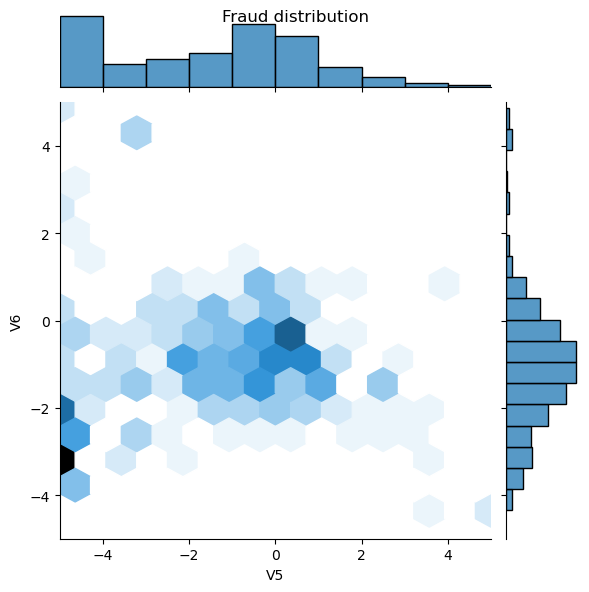

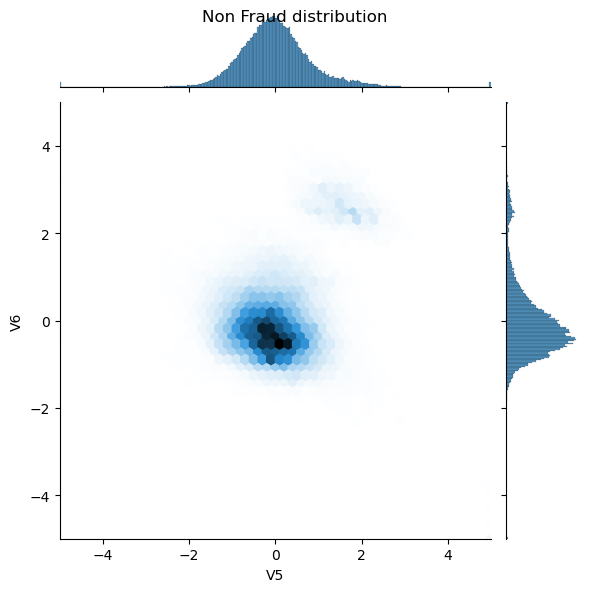

In [20]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Fraud distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Non Fraud distribution")

## The evaluation metrics

#### Metrics for deterministic 0/1 predictions

In the end, one often wants to predict a class label, 0 or 1, *no fraud* or *fraud*.

To get a label prediction from our probabilistic classifier, one needs to choose a probability threshold $c$.

The default is to predict label 1 (fraud) if the predicted probability is larger than $c=50\%$ and all the following metrics implicitly use this default. 

*   **False** negatives and **false** positives are observations that were **incorrectly** classified
*   **True** negatives and **true** positives are observations that were **correctly** classified
*   **Accuracy** is the percentage of observations correctly classified
 
 $$\frac{\text{Correctly Classified observations}}{\text{total observations}}$$
 
*   **Precision** is the percentage of **predicted** positives that were correctly classified
$$\frac{\text{true positives}}{\text{true positives + false positives}}$$
*   **Recall** is the percentage of **actual** positives that were correctly classified
$$\frac{\text{true positives}}{\text{true positives + false negatives}}$$

**Note:** Accuracy is not a helpful metric for this task. You can have 99.8%+ accuracy on this task by predicting False all the time.  

#### Other metrices

The Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC) take into account all possible choices of thresholds $c$.. This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
 



In [21]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]


## The Neural Network model

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

<div >
    <img src = "figures/red_neuronal.png" />
</div>

In [22]:

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(16, activation='relu',input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [23]:
train_features.shape[-1]

29

## Baseline model

### Build the model

Now create and train our first model using the function that was defined earlier. 


In [24]:
EPOCHS = 100
BATCH_SIZE = 2048 #funcionan bien 2^(a la algo)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='recall', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


In [25]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497 (1.94 KB)
Trainable params: 497 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
29*16+16

480

Test run the model:

In [28]:
model.predict(train_features[:10])

1/1 [==============================] - 0s 110ms/step


array([[0.5379405 ],
       [0.4709622 ],
       [0.5988311 ],
       [0.4306941 ],
       [0.5700306 ],
       [0.44500852],
       [0.65235126],
       [0.86862177],
       [0.722458  ],
       [0.45281738]], dtype=float32)

### Optional: Set the correct initial bias.

- These initial guesses are not great. 

- We know the dataset is imbalanced. Set the output layer's bias to reflect that, see [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [29]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.0497


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [32]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [33]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - 0s 45ms/step


array([[0.0018556 ],
       [0.00044498],
       [0.00182333],
       [0.00132485],
       [0.00141284],
       [0.00098628],
       [0.00155409],
       [0.00148646],
       [0.00236309],
       [0.00143617]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [34]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0152


This initial loss is order of magnitude less than it would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. It also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [35]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [36]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])

zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [37]:
model = make_model()
model.load_weights(initial_weights)

careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [38]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

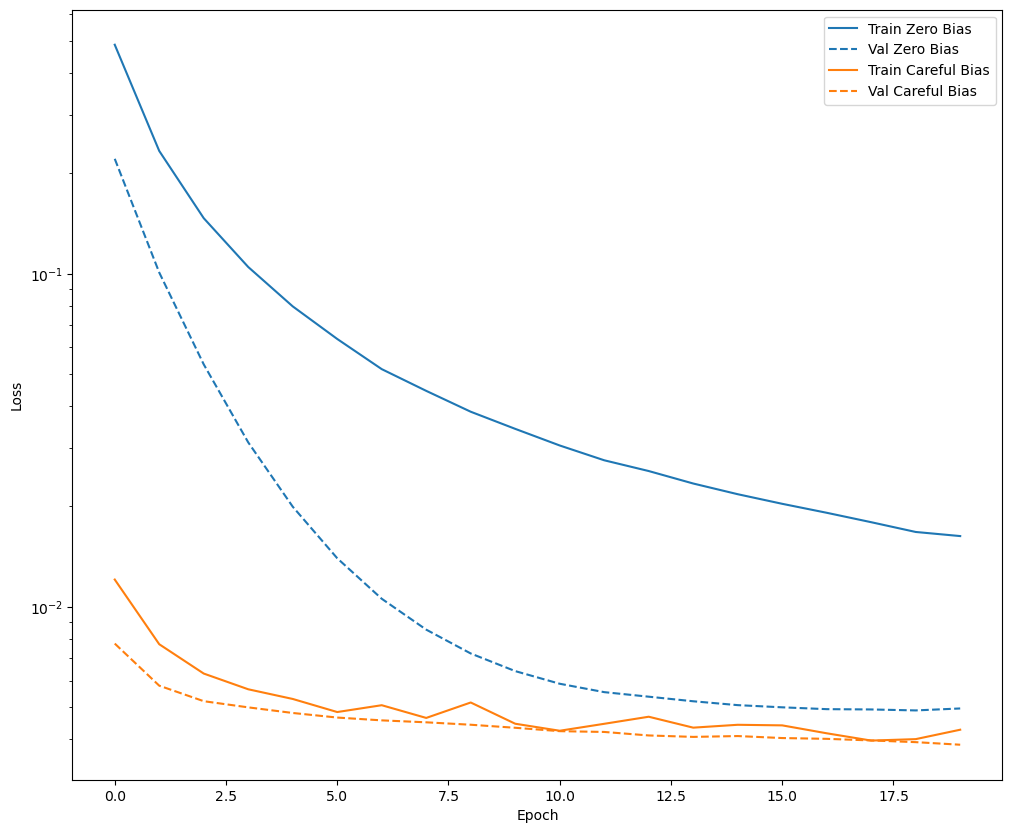

In [39]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [40]:
model = make_model()
model.load_weights(initial_weights)

baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 2s 9ms/step - loss: 0.0117 - cross entropy: 0.0101 - tp: 109.0000 - fp: 34.0000 - tn: 227416.0000 - fn: 286.0000 - accuracy: 0.9986 - precision: 0.7622 - recall: 0.2759 - auc: 0.7744 - val_loss: 0.0078 - val_cross entropy: 0.0078 - val_tp: 14.0000 - val_fp: 3.0000 - val_tn: 45477.0000 - val_fn: 75.0000 - val_accuracy: 0.9983 - val_precision: 0.8235 - val_recall: 0.1573 - val_auc: 0.8867
Epoch 2/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0076 - cross entropy: 0.0076 - tp: 104.0000 - fp: 24.0000 - tn: 181946.0000 - fn: 202.0000 - accuracy: 0.9988 - precision: 0.8125 - recall: 0.3399 - auc: 0.8540 - val_loss: 0.0057 - val_cross entropy: 0.0057 - val_tp: 41.0000 - val_fp: 8.0000 - val_tn: 45472.0000 - val_fn: 48.0000 - val_accuracy: 0.9988 - val_precision: 0.8367 - val_recall: 0.4607 - val_auc: 0.9097
Epoch 3/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0065 - cross entropy: 0.0065 - tp: 131.

90/90 [==============================] - 1s 7ms/step - loss: 0.0041 - cross entropy: 0.0041 - tp: 186.0000 - fp: 32.0000 - tn: 181938.0000 - fn: 120.0000 - accuracy: 0.9992 - precision: 0.8532 - recall: 0.6078 - auc: 0.9174 - val_loss: 0.0040 - val_cross entropy: 0.0040 - val_tp: 62.0000 - val_fp: 11.0000 - val_tn: 45469.0000 - val_fn: 27.0000 - val_accuracy: 0.9992 - val_precision: 0.8493 - val_recall: 0.6966 - val_auc: 0.9267
Epoch 20/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0041 - cross entropy: 0.0041 - tp: 183.0000 - fp: 30.0000 - tn: 181940.0000 - fn: 123.0000 - accuracy: 0.9992 - precision: 0.8592 - recall: 0.5980 - auc: 0.9255 - val_loss: 0.0039 - val_cross entropy: 0.0039 - val_tp: 61.0000 - val_fp: 10.0000 - val_tn: 45470.0000 - val_fn: 28.0000 - val_accuracy: 0.9992 - val_precision: 0.8592 - val_recall: 0.6854 - val_auc: 0.9266
Epoch 21/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0040 - cross entropy: 0.0040 - tp: 180.0000 - f

90/90 [==============================] - 0s 4ms/step - loss: 0.0035 - cross entropy: 0.0035 - tp: 194.0000 - fp: 30.0000 - tn: 181940.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8661 - recall: 0.6340 - auc: 0.9289 - val_loss: 0.0038 - val_cross entropy: 0.0038 - val_tp: 67.0000 - val_fp: 8.0000 - val_tn: 45472.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8933 - val_recall: 0.7528 - val_auc: 0.9266
Epoch 38/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0037 - cross entropy: 0.0037 - tp: 188.0000 - fp: 21.0000 - tn: 181949.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8995 - recall: 0.6144 - auc: 0.9355 - val_loss: 0.0038 - val_cross entropy: 0.0038 - val_tp: 68.0000 - val_fp: 11.0000 - val_tn: 45469.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8608 - val_recall: 0.7640 - val_auc: 0.9266
Epoch 39/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - cross entropy: 0.0036 - tp: 191.0000 - fp

### Check training history


In [41]:
def plot_metrics(history):
  metrics = ['loss', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

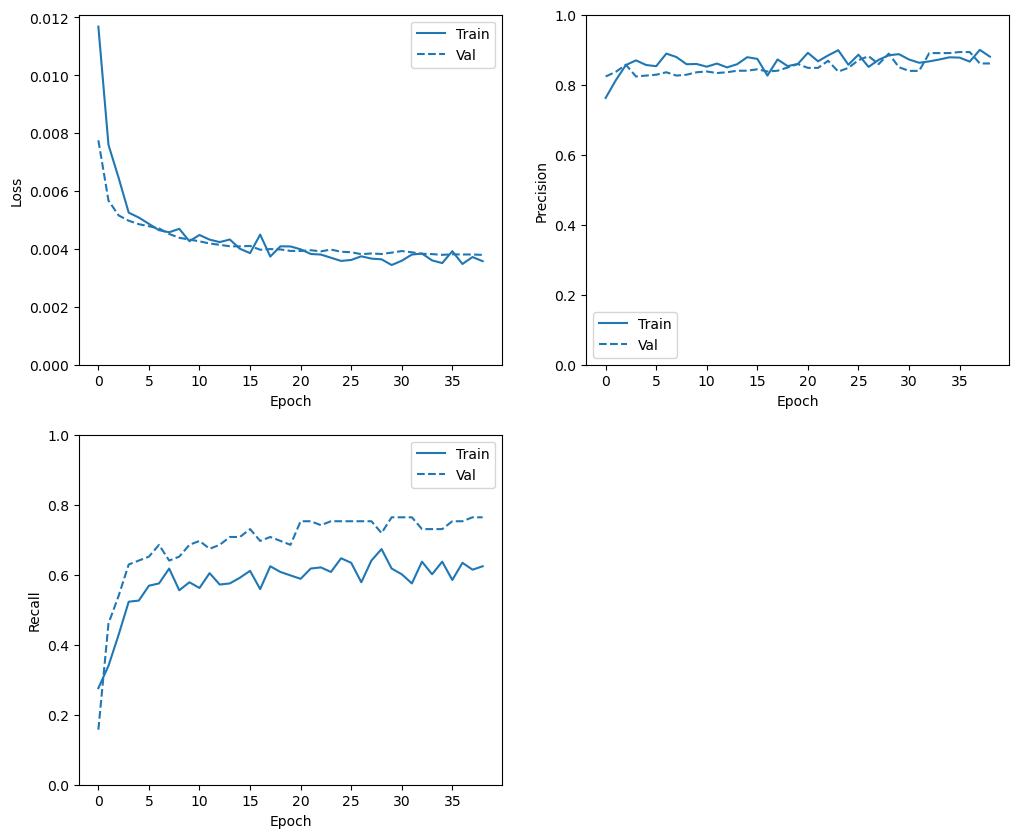

In [42]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

We can use a confusion matrix to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [43]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)

test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 1ms/step


In [44]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above:

loss :  0.003140145679935813
cross entropy :  0.003140145679935813
tp :  70.0
fp :  7.0
tn :  56858.0
fn :  27.0
accuracy :  0.9994031190872192
precision :  0.9090909361839294
recall :  0.7216494679450989
auc :  0.9172210693359375

Legitimate Transactions Detected (True Negatives):  56858
Legitimate Transactions Incorrectly Detected (False Positives):  7
Fraudulent Transactions Missed (False Negatives):  27
Fraudulent Transactions Detected (True Positives):  70
Total Fraudulent Transactions:  97


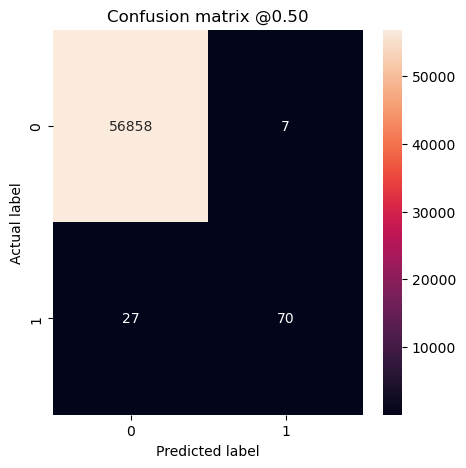

In [45]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

### Changing the threshold

The default threshold of $c=50\%$ corresponds to equal costs of false negatives and false positives.

In the case of fraud detection, however, you would likely associate higher costs to false negatives than to false positives.

This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

By decreasing the threshold, we attribute higher cost to false negatives, thereby increasing missed transactions at the price of more false positives.
We test thresholds at 10% and at 1%.

Legitimate Transactions Detected (True Negatives):  56849
Legitimate Transactions Incorrectly Detected (False Positives):  16
Fraudulent Transactions Missed (False Negatives):  20
Fraudulent Transactions Detected (True Positives):  77
Total Fraudulent Transactions:  97


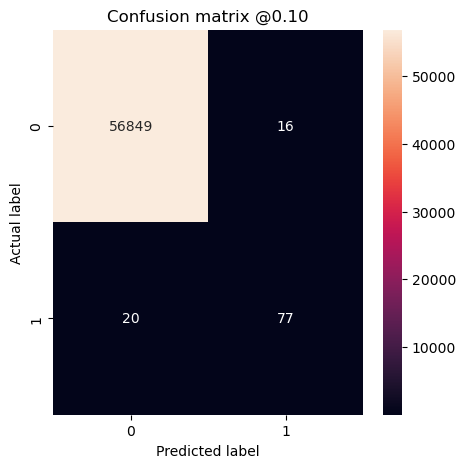

In [46]:
plot_cm(test_labels, test_predictions_baseline, threshold=0.1)

Legitimate Transactions Detected (True Negatives):  56817
Legitimate Transactions Incorrectly Detected (False Positives):  48
Fraudulent Transactions Missed (False Negatives):  17
Fraudulent Transactions Detected (True Positives):  80
Total Fraudulent Transactions:  97


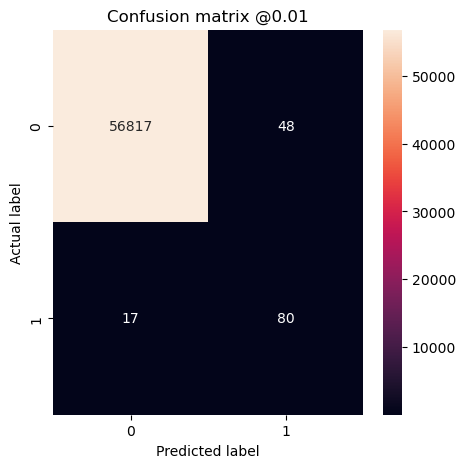

In [47]:
plot_cm(test_labels, test_predictions_baseline, threshold=0.01)

### Plot the ROC


In [69]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

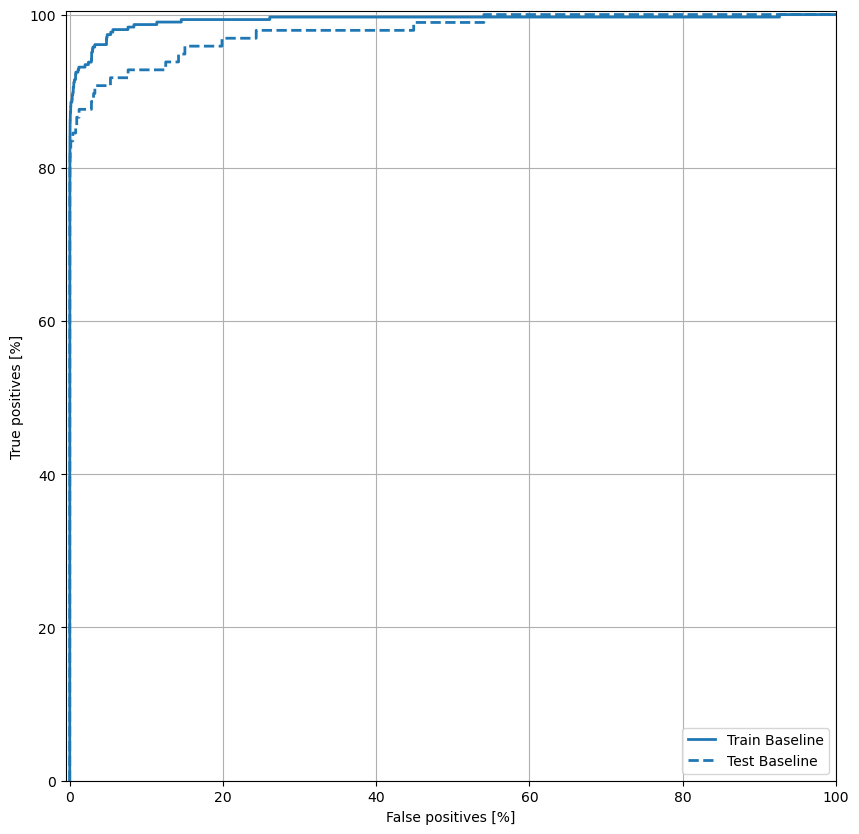

In [70]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

## Class weights

### Calculate class weights

- The goal is to identify fraudulent transactions, but we don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. 

- We can do this by passing Keras weights for each class through a parameter. 

- These will cause the model to "pay more attention" to examples from an under-represented class. 

Note,  this does not increase in any way the amount of information of your dataset, this is just a way to try to get a "better model"

In [50]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [51]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
90/90 [==============================] - 2s 10ms/step - loss: 2.5105 - cross entropy: 0.0113 - tp: 125.0000 - fp: 113.0000 - tn: 238722.0000 - fn: 278.0000 - accuracy: 0.9984 - precision: 0.5252 - recall: 0.3102 - auc: 0.7740 - val_loss: 0.0077 - val_cross entropy: 0.0077 - val_tp: 32.0000 - val_fp: 7.0000 - val_tn: 45473.0000 - val_fn: 57.0000 - val_accuracy: 0.9986 - val_precision: 0.8205 - val_recall: 0.3596 - val_auc: 0.9104
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 1.0439 - cross entropy: 0.0148 - tp: 142.0000 - fp: 352.0000 - tn: 181618.0000 - fn: 164.0000 - accuracy: 0.9972 - precision: 0.2874 - recall: 0.4641 - auc: 0.8839 - val_loss: 0.0087 - val_cross entropy: 0.0087 - val_tp: 62.0000 - val_fp: 16.0000 - val_tn: 45464.0000 - val_fn: 27.0000 - val_accuracy: 0.9991 - val_precision: 0.7949 - val_recall: 0.6966 - val_auc: 0.9355
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 0.6593 - cross entropy: 0.0211 - tp: 

90/90 [==============================] - 0s 5ms/step - loss: 0.2645 - cross entropy: 0.1236 - tp: 270.0000 - fp: 5807.0000 - tn: 176163.0000 - fn: 36.0000 - accuracy: 0.9679 - precision: 0.0444 - recall: 0.8824 - auc: 0.9547 - val_loss: 0.0683 - val_cross entropy: 0.0683 - val_tp: 76.0000 - val_fp: 747.0000 - val_tn: 44733.0000 - val_fn: 13.0000 - val_accuracy: 0.9833 - val_precision: 0.0923 - val_recall: 0.8539 - val_auc: 0.9721
Epoch 20/100
90/90 [==============================] - 0s 5ms/step - loss: 0.2914 - cross entropy: 0.1223 - tp: 263.0000 - fp: 5829.0000 - tn: 176141.0000 - fn: 43.0000 - accuracy: 0.9678 - precision: 0.0432 - recall: 0.8595 - auc: 0.9516 - val_loss: 0.0713 - val_cross entropy: 0.0713 - val_tp: 76.0000 - val_fp: 784.0000 - val_tn: 44696.0000 - val_fn: 13.0000 - val_accuracy: 0.9825 - val_precision: 0.0884 - val_recall: 0.8539 - val_auc: 0.9727
Epoch 21/100
90/90 [==============================] - 0s 5ms/step - loss: 0.2611 - cross entropy: 0.1263 - tp: 269.0000

90/90 [==============================] - 0s 5ms/step - loss: 0.1790 - cross entropy: 0.1089 - tp: 277.0000 - fp: 5280.0000 - tn: 176690.0000 - fn: 29.0000 - accuracy: 0.9709 - precision: 0.0498 - recall: 0.9052 - auc: 0.9804 - val_loss: 0.0686 - val_cross entropy: 0.0686 - val_tp: 78.0000 - val_fp: 738.0000 - val_tn: 44742.0000 - val_fn: 11.0000 - val_accuracy: 0.9836 - val_precision: 0.0956 - val_recall: 0.8764 - val_auc: 0.9720
Epoch 38/100
90/90 [==============================] - 0s 4ms/step - loss: 0.1607 - cross entropy: 0.1105 - tp: 282.0000 - fp: 5280.0000 - tn: 176690.0000 - fn: 24.0000 - accuracy: 0.9709 - precision: 0.0507 - recall: 0.9216 - auc: 0.9829 - val_loss: 0.0684 - val_cross entropy: 0.0684 - val_tp: 78.0000 - val_fp: 738.0000 - val_tn: 44742.0000 - val_fn: 11.0000 - val_accuracy: 0.9836 - val_precision: 0.0956 - val_recall: 0.8764 - val_auc: 0.9725
Epoch 39/100
90/90 [==============================] - 0s 4ms/step - loss: 0.2369 - cross entropy: 0.1096 - tp: 269.0000

### Check training history

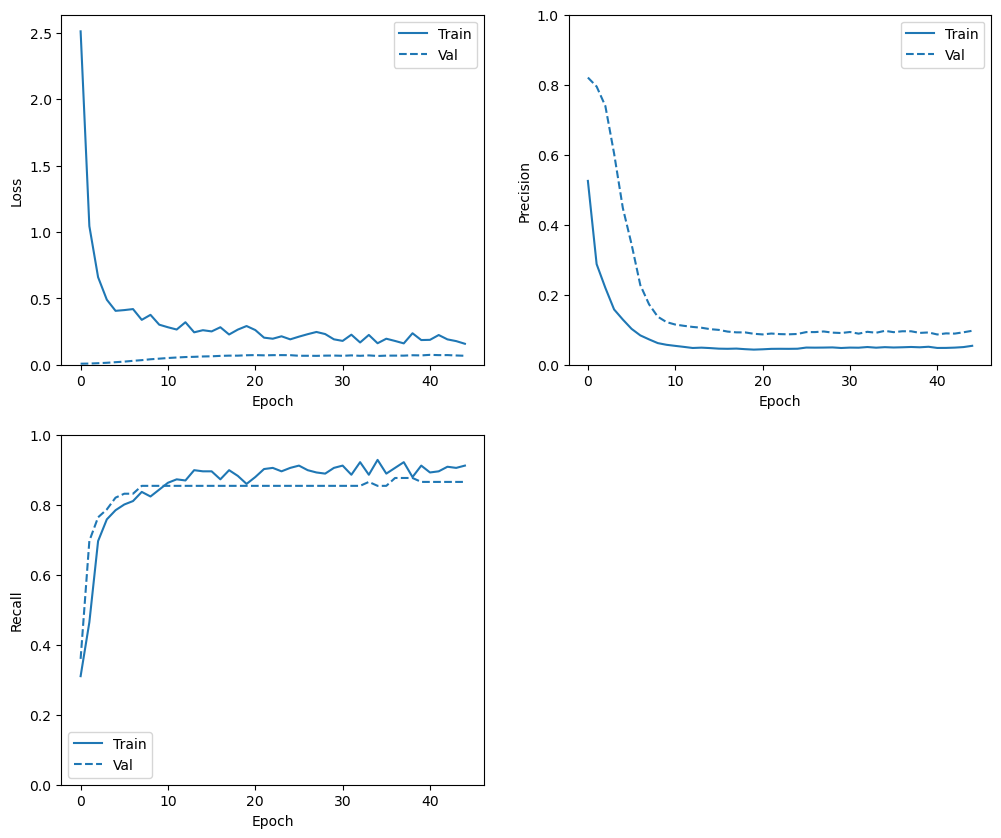

In [52]:
plot_metrics(weighted_history)

### Evaluate metrics

In [53]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 3ms/step


loss :  0.0654679462313652
cross entropy :  0.0654679462313652
tp :  84.0
fp :  863.0
tn :  56002.0
fn :  13.0
accuracy :  0.9846213459968567
precision :  0.08870115876197815
recall :  0.8659793734550476
auc :  0.9806591868400574

Legitimate Transactions Detected (True Negatives):  56002
Legitimate Transactions Incorrectly Detected (False Positives):  863
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  97


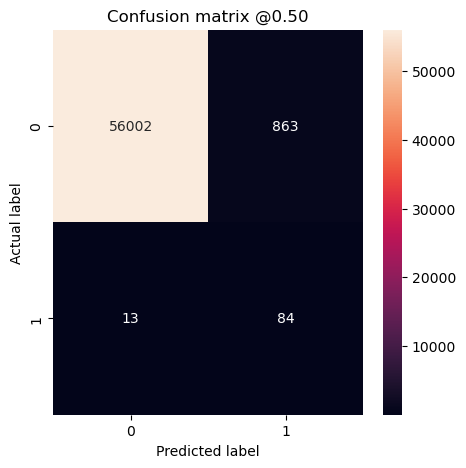

In [54]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall is higher because the model also found more true positives. 

Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions than the baseline model at threshold 50%). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). 



### Plot the ROC

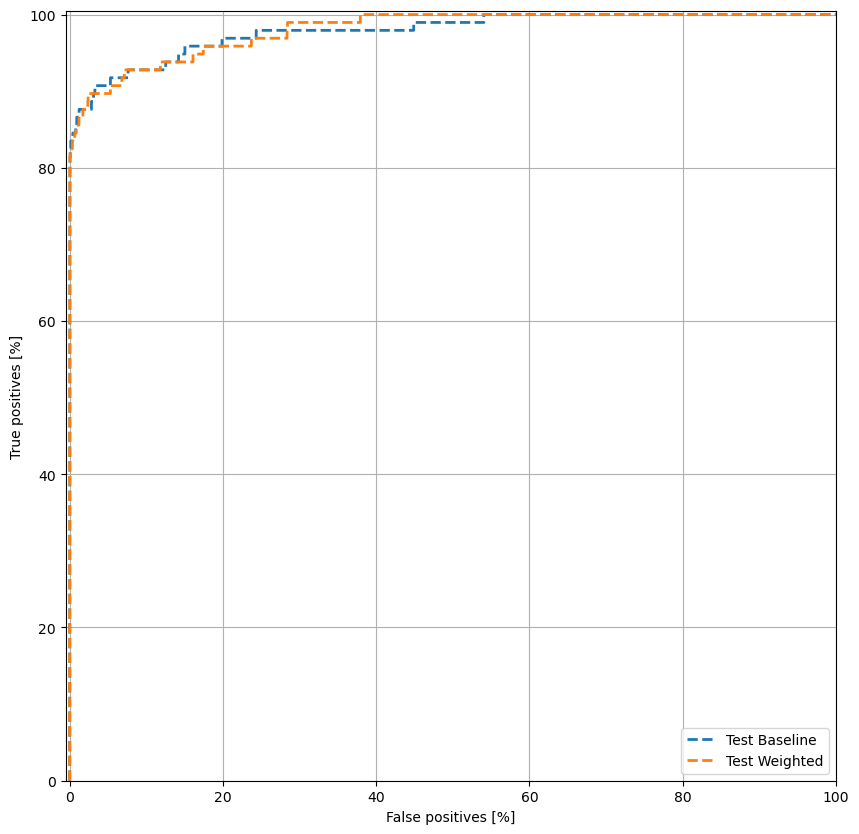

In [73]:
#plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

#plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

Compared to the baseline model with changed threshold, the class weighted model is clearly inferior. 


## Resampling

There are two general approaches:

   1. Over-sampling. Simulates or imputes additional data points of the minority class to improve balance across classes, while
     
   2. Down-sampling. You randomly reduce the number of the majority class to improve the balance across classes.

and a hybrid: SMOTE (Synthetic Minority Over-sampling Technique)


<div >
<img src = "figures/sampling_methods.png" />
</div>

## Oversampling

### Oversample the minority class


In [56]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using `tf.data`

Using tf.data with oversampling involves a few steps because tf.data is designed to work with TensorFlow's pipeline, while we need to create the sample with NumPy arrays

We can balance the dataset manually by choosing the right number of random  indices from the positive examples.

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them.  

In [57]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels)).cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [58]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-1.58365953  0.35468102 -3.55267554  1.28535739 -0.61151932 -2.21725598
 -1.7981993   0.88853656 -1.48872489 -4.81013571  1.8919569  -5.
 -1.13330188 -5.          0.153299   -2.90757818 -5.         -1.76291003
 -0.04300302  0.40060559  0.79439604 -0.37151861 -0.71890105 -0.3060648
 -0.62740552  1.25698051  2.21988119 -0.80592661  1.26448625]

Label:  1


Merge the two together using `tf.data.Dataset.sample_from_datasets`:

In [59]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [60]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.49609375


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [61]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Now we traing the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [62]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 11s 34ms/step - loss: 0.4749 - cross entropy: 0.4377 - tp: 233516.0000 - fp: 64592.0000 - tn: 277022.0000 - fn: 51176.0000 - accuracy: 0.8152 - precision: 0.7833 - recall: 0.8202 - auc: 0.8922 - val_loss: 0.1939 - val_cross entropy: 0.1939 - val_tp: 76.0000 - val_fp: 1206.0000 - val_tn: 44274.0000 - val_fn: 13.0000 - val_accuracy: 0.9732 - val_precision: 0.0593 - val_recall: 0.8539 - val_auc: 0.9617
Epoch 2/100
278/278 [==============================] - 7s 25ms/step - loss: 0.1907 - cross entropy: 0.1907 - tp: 257027.0000 - fp: 15602.0000 - tn: 269276.0000 - fn: 27439.0000 - accuracy: 0.9244 - precision: 0.9428 - recall: 0.9035 - auc: 0.9762 - val_loss: 0.0987 - val_cross entropy: 0.0987 - val_tp: 76.0000 - val_fp: 842.0000 - val_tn: 44638.0000 - val_fn: 13.0000 - val_accuracy: 0.9812 - val_precision: 0.0828 - val_recall: 0.8539 - val_auc: 0.9681
Epoch 3/100
278/278 [==============================] - 8s 30ms/step - loss: 0.1474 - c

Epoch 19/100
278/278 [==============================] - 8s 29ms/step - loss: 0.0564 - cross entropy: 0.0564 - tp: 284001.0000 - fp: 11241.0000 - tn: 273674.0000 - fn: 428.0000 - accuracy: 0.9795 - precision: 0.9619 - recall: 0.9985 - auc: 0.9981 - val_loss: 0.0240 - val_cross entropy: 0.0240 - val_tp: 76.0000 - val_fp: 350.0000 - val_tn: 45130.0000 - val_fn: 13.0000 - val_accuracy: 0.9920 - val_precision: 0.1784 - val_recall: 0.8539 - val_auc: 0.9507
Epoch 20/100
278/278 [==============================] - 8s 28ms/step - loss: 0.0550 - cross entropy: 0.0550 - tp: 284431.0000 - fp: 10983.0000 - tn: 273697.0000 - fn: 233.0000 - accuracy: 0.9803 - precision: 0.9628 - recall: 0.9992 - auc: 0.9981 - val_loss: 0.0232 - val_cross entropy: 0.0232 - val_tp: 76.0000 - val_fp: 338.0000 - val_tn: 45142.0000 - val_fn: 13.0000 - val_accuracy: 0.9923 - val_precision: 0.1836 - val_recall: 0.8539 - val_auc: 0.9509
Epoch 21/100
278/278 [==============================] - 8s 28ms/step - loss: 0.0531 - cros

278/278 [==============================] - 8s 30ms/step - loss: 0.0428 - cross entropy: 0.0428 - tp: 285156.0000 - fp: 9282.0000 - tn: 274905.0000 - fn: 1.0000 - accuracy: 0.9837 - precision: 0.9685 - recall: 1.0000 - auc: 0.9985 - val_loss: 0.0191 - val_cross entropy: 0.0191 - val_tp: 75.0000 - val_fp: 211.0000 - val_tn: 45269.0000 - val_fn: 14.0000 - val_accuracy: 0.9951 - val_precision: 0.2622 - val_recall: 0.8427 - val_auc: 0.9367
Epoch 38/100
278/278 [==============================] - 7s 26ms/step - loss: 0.0421 - cross entropy: 0.0421 - tp: 285092.0000 - fp: 9061.0000 - tn: 275188.0000 - fn: 3.0000 - accuracy: 0.9841 - precision: 0.9692 - recall: 1.0000 - auc: 0.9985 - val_loss: 0.0196 - val_cross entropy: 0.0196 - val_tp: 75.0000 - val_fp: 209.0000 - val_tn: 45271.0000 - val_fn: 14.0000 - val_accuracy: 0.9951 - val_precision: 0.2641 - val_recall: 0.8427 - val_auc: 0.9367
Epoch 39/100
278/278 [==============================] - 7s 25ms/step - loss: 0.0414 - cross entropy: 0.0414 -

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

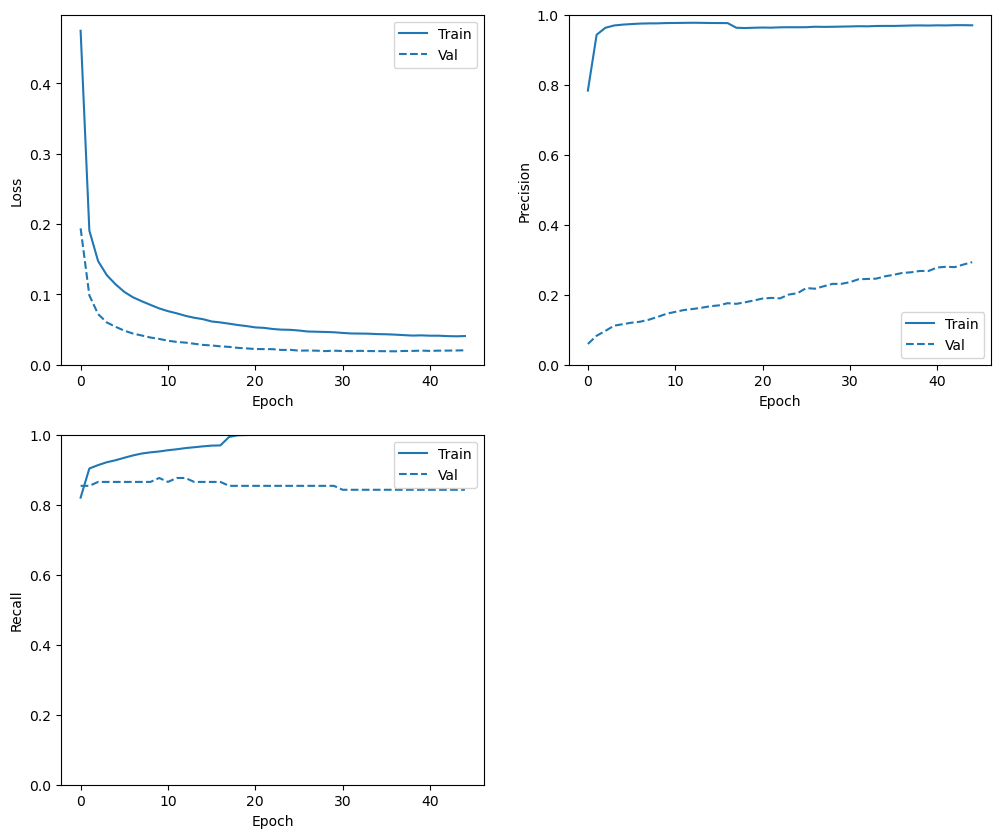

In [63]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `tf.keras.callbacks.EarlyStopping` finer control over when to stop training.

In [64]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 2s 48ms/step - loss: 1.3749 - cross entropy: 0.6616 - tp: 9907.0000 - fp: 8817.0000 - tn: 57250.0000 - fn: 10555.0000 - accuracy: 0.7761 - precision: 0.5291 - recall: 0.4842 - auc: 0.7987 - val_loss: 0.6416 - val_cross entropy: 0.6416 - val_tp: 68.0000 - val_fp: 17009.0000 - val_tn: 28471.0000 - val_fn: 21.0000 - val_accuracy: 0.6263 - val_precision: 0.0040 - val_recall: 0.7640 - val_auc: 0.7893
Epoch 2/1000
20/20 [==============================] - 1s 28ms/step - loss: 0.8771 - cross entropy: 0.8771 - tp: 13576.0000 - fp: 8471.0000 - tn: 11911.0000 - fn: 7002.0000 - accuracy: 0.6222 - precision: 0.6158 - recall: 0.6597 - auc: 0.6781 - val_loss: 0.6121 - val_cross entropy: 0.6121 - val_tp: 82.0000 - val_fp: 15323.0000 - val_tn: 30157.0000 - val_fn: 7.0000 - val_accuracy: 0.6636 - val_precision: 0.0053 - val_recall: 0.9213 - val_auc: 0.9161
Epoch 3/1000
20/20 [==============================] - 1s 30ms/step - loss: 0.6475 - cross entro

20/20 [==============================] - 1s 34ms/step - loss: 0.2011 - cross entropy: 0.2011 - tp: 18437.0000 - fp: 1263.0000 - tn: 19212.0000 - fn: 2048.0000 - accuracy: 0.9192 - precision: 0.9359 - recall: 0.9000 - auc: 0.9737 - val_loss: 0.1401 - val_cross entropy: 0.1401 - val_tp: 76.0000 - val_fp: 959.0000 - val_tn: 44521.0000 - val_fn: 13.0000 - val_accuracy: 0.9787 - val_precision: 0.0734 - val_recall: 0.8539 - val_auc: 0.9655
Epoch 20/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.1920 - cross entropy: 0.1920 - tp: 18542.0000 - fp: 1072.0000 - tn: 19355.0000 - fn: 1991.0000 - accuracy: 0.9252 - precision: 0.9453 - recall: 0.9030 - auc: 0.9759 - val_loss: 0.1337 - val_cross entropy: 0.1337 - val_tp: 76.0000 - val_fp: 954.0000 - val_tn: 44526.0000 - val_fn: 13.0000 - val_accuracy: 0.9788 - val_precision: 0.0738 - val_recall: 0.8539 - val_auc: 0.9663
Epoch 21/1000
20/20 [==============================] - 1s 40ms/step - loss: 0.1868 - cross entropy: 0.1868 - t

20/20 [==============================] - 1s 35ms/step - loss: 0.1455 - cross entropy: 0.1455 - tp: 18627.0000 - fp: 718.0000 - tn: 19850.0000 - fn: 1765.0000 - accuracy: 0.9394 - precision: 0.9629 - recall: 0.9134 - auc: 0.9871 - val_loss: 0.0784 - val_cross entropy: 0.0784 - val_tp: 76.0000 - val_fp: 741.0000 - val_tn: 44739.0000 - val_fn: 13.0000 - val_accuracy: 0.9835 - val_precision: 0.0930 - val_recall: 0.8539 - val_auc: 0.9696
Epoch 38/1000
20/20 [==============================] - 1s 42ms/step - loss: 0.1400 - cross entropy: 0.1400 - tp: 18835.0000 - fp: 658.0000 - tn: 19755.0000 - fn: 1712.0000 - accuracy: 0.9421 - precision: 0.9662 - recall: 0.9167 - auc: 0.9880 - val_loss: 0.0766 - val_cross entropy: 0.0766 - val_tp: 76.0000 - val_fp: 733.0000 - val_tn: 44747.0000 - val_fn: 13.0000 - val_accuracy: 0.9836 - val_precision: 0.0939 - val_recall: 0.8539 - val_auc: 0.9699
Epoch 39/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.1397 - cross entropy: 0.1397 - tp:

20/20 [==============================] - 1s 28ms/step - loss: 0.1194 - cross entropy: 0.1194 - tp: 18907.0000 - fp: 566.0000 - tn: 19939.0000 - fn: 1548.0000 - accuracy: 0.9484 - precision: 0.9709 - recall: 0.9243 - auc: 0.9917 - val_loss: 0.0602 - val_cross entropy: 0.0602 - val_tp: 77.0000 - val_fp: 596.0000 - val_tn: 44884.0000 - val_fn: 12.0000 - val_accuracy: 0.9867 - val_precision: 0.1144 - val_recall: 0.8652 - val_auc: 0.9723
Epoch 56/1000
20/20 [==============================] - 1s 27ms/step - loss: 0.1217 - cross entropy: 0.1217 - tp: 18862.0000 - fp: 549.0000 - tn: 20003.0000 - fn: 1546.0000 - accuracy: 0.9489 - precision: 0.9717 - recall: 0.9242 - auc: 0.9912 - val_loss: 0.0597 - val_cross entropy: 0.0597 - val_tp: 77.0000 - val_fp: 592.0000 - val_tn: 44888.0000 - val_fn: 12.0000 - val_accuracy: 0.9867 - val_precision: 0.1151 - val_recall: 0.8652 - val_auc: 0.9726
Epoch 57/1000
20/20 [==============================] - 1s 35ms/step - loss: 0.1201 - cross entropy: 0.1201 - tp:

20/20 [==============================] - 1s 34ms/step - loss: 0.1060 - cross entropy: 0.1060 - tp: 19206.0000 - fp: 536.0000 - tn: 19884.0000 - fn: 1334.0000 - accuracy: 0.9543 - precision: 0.9728 - recall: 0.9351 - auc: 0.9938 - val_loss: 0.0528 - val_cross entropy: 0.0528 - val_tp: 77.0000 - val_fp: 576.0000 - val_tn: 44904.0000 - val_fn: 12.0000 - val_accuracy: 0.9871 - val_precision: 0.1179 - val_recall: 0.8652 - val_auc: 0.9738
Epoch 74/1000
20/20 [==============================] - 1s 36ms/step - loss: 0.1058 - cross entropy: 0.1058 - tp: 19125.0000 - fp: 549.0000 - tn: 19966.0000 - fn: 1320.0000 - accuracy: 0.9544 - precision: 0.9721 - recall: 0.9354 - auc: 0.9938 - val_loss: 0.0518 - val_cross entropy: 0.0518 - val_tp: 77.0000 - val_fp: 554.0000 - val_tn: 44926.0000 - val_fn: 12.0000 - val_accuracy: 0.9876 - val_precision: 0.1220 - val_recall: 0.8652 - val_auc: 0.9733
Epoch 75/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.1036 - cross entropy: 0.1036 - tp:

20/20 [==============================] - 1s 30ms/step - loss: 0.0972 - cross entropy: 0.0972 - tp: 19293.0000 - fp: 501.0000 - tn: 19950.0000 - fn: 1216.0000 - accuracy: 0.9581 - precision: 0.9747 - recall: 0.9407 - auc: 0.9948 - val_loss: 0.0459 - val_cross entropy: 0.0459 - val_tp: 77.0000 - val_fp: 551.0000 - val_tn: 44929.0000 - val_fn: 12.0000 - val_accuracy: 0.9876 - val_precision: 0.1226 - val_recall: 0.8652 - val_auc: 0.9717
Epoch 92/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.0942 - cross entropy: 0.0942 - tp: 19316.0000 - fp: 463.0000 - tn: 19961.0000 - fn: 1220.0000 - accuracy: 0.9589 - precision: 0.9766 - recall: 0.9406 - auc: 0.9952 - val_loss: 0.0456 - val_cross entropy: 0.0456 - val_tp: 77.0000 - val_fp: 545.0000 - val_tn: 44935.0000 - val_fn: 12.0000 - val_accuracy: 0.9878 - val_precision: 0.1238 - val_recall: 0.8652 - val_auc: 0.9677
Epoch 93/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0949 - cross entropy: 0.0949 - tp:

20/20 [==============================] - 1s 31ms/step - loss: 0.0916 - cross entropy: 0.0916 - tp: 19395.0000 - fp: 499.0000 - tn: 19962.0000 - fn: 1104.0000 - accuracy: 0.9609 - precision: 0.9749 - recall: 0.9461 - auc: 0.9956 - val_loss: 0.0416 - val_cross entropy: 0.0416 - val_tp: 77.0000 - val_fp: 498.0000 - val_tn: 44982.0000 - val_fn: 12.0000 - val_accuracy: 0.9888 - val_precision: 0.1339 - val_recall: 0.8652 - val_auc: 0.9685
Epoch 110/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0893 - cross entropy: 0.0893 - tp: 19417.0000 - fp: 489.0000 - tn: 19967.0000 - fn: 1087.0000 - accuracy: 0.9615 - precision: 0.9754 - recall: 0.9470 - auc: 0.9957 - val_loss: 0.0413 - val_cross entropy: 0.0413 - val_tp: 77.0000 - val_fp: 499.0000 - val_tn: 44981.0000 - val_fn: 12.0000 - val_accuracy: 0.9888 - val_precision: 0.1337 - val_recall: 0.8652 - val_auc: 0.9685
Epoch 111/1000
20/20 [==============================] - 1s 29ms/step - loss: 0.0862 - cross entropy: 0.0862 - t

20/20 [==============================] - 1s 29ms/step - loss: 0.0812 - cross entropy: 0.0812 - tp: 19633.0000 - fp: 448.0000 - tn: 19885.0000 - fn: 994.0000 - accuracy: 0.9648 - precision: 0.9777 - recall: 0.9518 - auc: 0.9966 - val_loss: 0.0386 - val_cross entropy: 0.0386 - val_tp: 77.0000 - val_fp: 476.0000 - val_tn: 45004.0000 - val_fn: 12.0000 - val_accuracy: 0.9893 - val_precision: 0.1392 - val_recall: 0.8652 - val_auc: 0.9694
Epoch 128/1000
20/20 [==============================] - 1s 35ms/step - loss: 0.0833 - cross entropy: 0.0833 - tp: 19516.0000 - fp: 483.0000 - tn: 19900.0000 - fn: 1061.0000 - accuracy: 0.9623 - precision: 0.9758 - recall: 0.9484 - auc: 0.9963 - val_loss: 0.0384 - val_cross entropy: 0.0384 - val_tp: 77.0000 - val_fp: 473.0000 - val_tn: 45007.0000 - val_fn: 12.0000 - val_accuracy: 0.9894 - val_precision: 0.1400 - val_recall: 0.8652 - val_auc: 0.9646
Epoch 129/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0819 - cross entropy: 0.0819 - tp

20/20 [==============================] - 1s 32ms/step - loss: 0.0777 - cross entropy: 0.0777 - tp: 19613.0000 - fp: 480.0000 - tn: 19911.0000 - fn: 956.0000 - accuracy: 0.9649 - precision: 0.9761 - recall: 0.9535 - auc: 0.9968 - val_loss: 0.0357 - val_cross entropy: 0.0357 - val_tp: 78.0000 - val_fp: 440.0000 - val_tn: 45040.0000 - val_fn: 11.0000 - val_accuracy: 0.9901 - val_precision: 0.1506 - val_recall: 0.8764 - val_auc: 0.9658
Epoch 146/1000
20/20 [==============================] - 1s 30ms/step - loss: 0.0733 - cross entropy: 0.0733 - tp: 19599.0000 - fp: 454.0000 - tn: 19955.0000 - fn: 952.0000 - accuracy: 0.9657 - precision: 0.9774 - recall: 0.9537 - auc: 0.9971 - val_loss: 0.0355 - val_cross entropy: 0.0355 - val_tp: 78.0000 - val_fp: 433.0000 - val_tn: 45047.0000 - val_fn: 11.0000 - val_accuracy: 0.9903 - val_precision: 0.1526 - val_recall: 0.8764 - val_auc: 0.9656
Epoch 147/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0753 - cross entropy: 0.0753 - tp:

20/20 [==============================] - 1s 29ms/step - loss: 0.0679 - cross entropy: 0.0679 - tp: 19660.0000 - fp: 385.0000 - tn: 20086.0000 - fn: 829.0000 - accuracy: 0.9704 - precision: 0.9808 - recall: 0.9595 - auc: 0.9976 - val_loss: 0.0342 - val_cross entropy: 0.0342 - val_tp: 78.0000 - val_fp: 455.0000 - val_tn: 45025.0000 - val_fn: 11.0000 - val_accuracy: 0.9898 - val_precision: 0.1463 - val_recall: 0.8764 - val_auc: 0.9617
Epoch 164/1000
20/20 [==============================] - 1s 30ms/step - loss: 0.0700 - cross entropy: 0.0700 - tp: 19749.0000 - fp: 512.0000 - tn: 19904.0000 - fn: 795.0000 - accuracy: 0.9681 - precision: 0.9747 - recall: 0.9613 - auc: 0.9973 - val_loss: 0.0339 - val_cross entropy: 0.0339 - val_tp: 78.0000 - val_fp: 445.0000 - val_tn: 45035.0000 - val_fn: 11.0000 - val_accuracy: 0.9900 - val_precision: 0.1491 - val_recall: 0.8764 - val_auc: 0.9618
Epoch 165/1000
20/20 [==============================] - 1s 28ms/step - loss: 0.0727 - cross entropy: 0.0727 - tp:

### Re-check training history

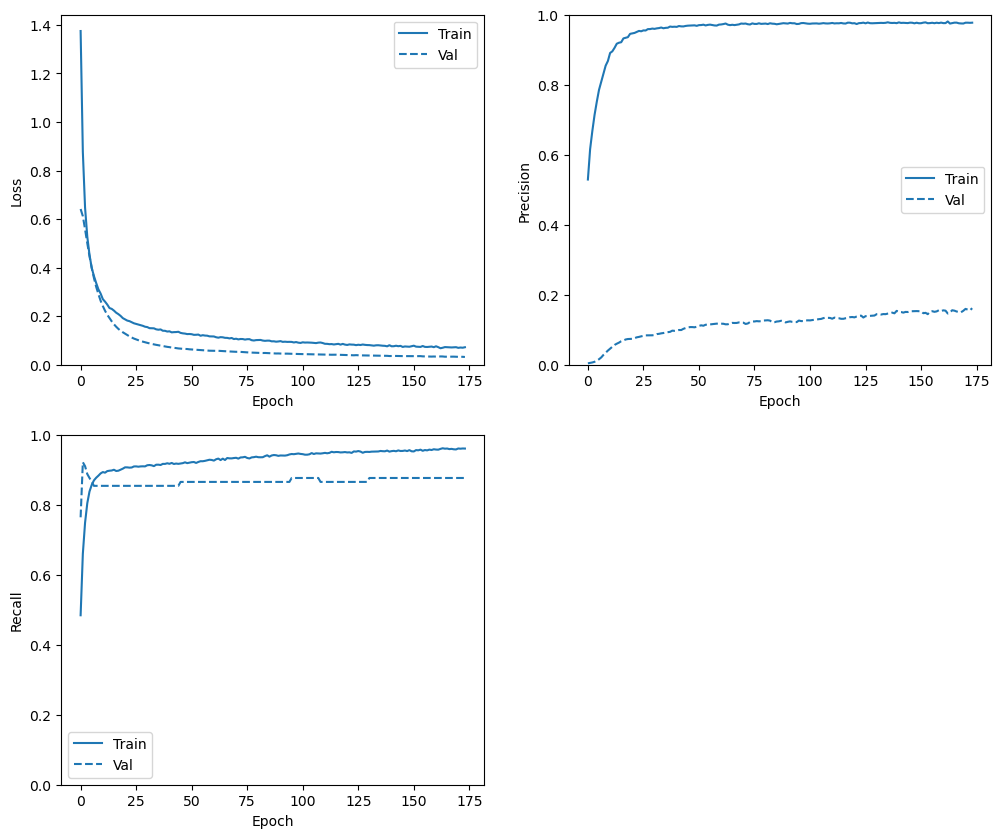

In [65]:
plot_metrics(resampled_history)

### Evaluate metrics

In [66]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 2ms/step


loss :  0.034519847482442856
cross entropy :  0.034519847482442856
tp :  83.0
fp :  552.0
tn :  56313.0
fn :  14.0
accuracy :  0.9900635480880737
precision :  0.13070866465568542
recall :  0.8556700944900513
auc :  0.9500564932823181

Legitimate Transactions Detected (True Negatives):  56313
Legitimate Transactions Incorrectly Detected (False Positives):  552
Fraudulent Transactions Missed (False Negatives):  14
Fraudulent Transactions Detected (True Positives):  83
Total Fraudulent Transactions:  97


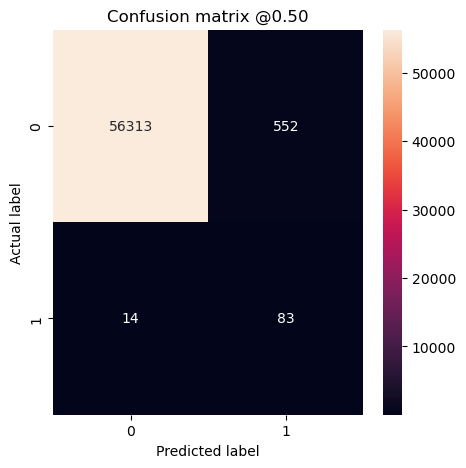

In [67]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

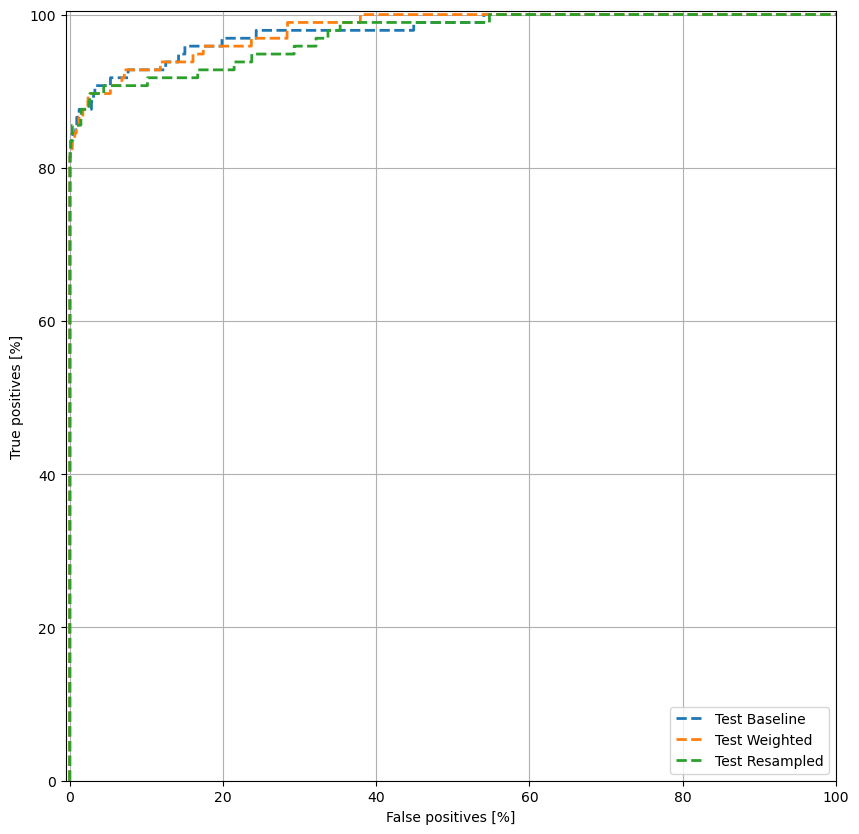

In [68]:
#plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
#plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
#plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## SMOTE

El synthetic minority over-sampling technique (SMOTE) (Chawla et al., 2002), utiliza tanto over-sampling como down-sampling

- Para mejorar la muestra de la clase minoritaria, SMOTE sintetiza nuevos casos. Para ello, se selecciona aleatoriamente un punto de datos de la clase minoritaria y se determinan sus K vecinos más cercanos (KNN). El nuevo punto de datos sintético es una combinación convexa aleatoria de los predictores del punto de datos seleccionado al azar y sus vecinos.

- Si bien el algoritmo SMOTE agrega nuevas muestras a la clase minoritaria a través de un muestreo ascendente, también puede reducir la muestra de casos de la clase mayoritaria a través de un muestreo aleatorio para ayudar a equilibrar el conjunto de entrenamiento.

<div >
<img src = "figures/smote.png" />
</div>

Using `tf.data` with SMOTE (Synthetic Minority Over-sampling Technique) involves a few steps because `tf.data` is designed to work with TensorFlow's pipeline, while SMOTE is a technique from the imbalanced-learn library that operates on NumPy arrays or pandas DataFrames. Here's a general approach to integrate SMOTE with a tf.data pipeline: